In [1]:
# ms-python.python added
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
try:
    os.chdir(os.path.join(os.getcwd(), 'notebooks/report'))
    print(os.getcwd())
except:
    pass


In [2]:
get_ipython().run_line_magic('matplotlib', 'inline')
sns.set()

In [3]:
cd /mnt/sda/otani/Experiments/moment_retrieval/

/mnt/sda/otani/Experiments/moment_retrieval


# Query-based temporal candidate generation

Input: description

Output: \mu and \sigma of starting point and duration

In [4]:
import torch
from torch import nn
from torch.distributions import MultivariateNormal, Independent
from torchvision.ops import roi_align

class QueryEmbedNet(nn.Module):
    def __init__(self, n_vocab, latent_size=100):
        super(QueryEmbedNet, self).__init__()
        
        self.emb = nn.Embedding(n_vocab+1, embedding_dim=100, padding_idx=n_vocab)
        self.lstm = nn.LSTM(100, latent_size)
        
    def forward(self, x):
        embeddings = self.emb(x)
        _, (h_n, _) = self.lstm(embeddings)
        return h_n.squeeze()
        

class BoundaryDist(nn.Module):
    def __init__(self, latent_size=100):
        super(BoundaryDist, self).__init__()
        self.scale_l = nn.Linear(latent_size, 2)
        self.cov_l = nn.Linear(latent_size, 1)
        self.loc_l = nn.Linear(latent_size, 2)
        
    def forward(self, x):
        scale = torch.sigmoid(self.scale_l(x))
        cov = torch.tanh(self.cov_l(x))
        
        scale = torch.diag_embed(scale)
        scale[:,1,0] = torch.flatten(cov)
        
        loc = torch.sigmoid(self.loc_l(x))
        
        dist = MultivariateNormal(loc, scale_tril=scale)
        return dist
    
class VideoNet(nn.Module):
    def __init__(self, in_size, latent_size=100):
        super(VideoNet, self).__init__()
        self.fc_1 = nn.Linear(in_size,latent_size)
        self.fc_2 = nn.Linear(latent_size,1)
        
    def forward(self, x, boxes):
        """
        x: video B x C x 1 x T
        boxes: list of box 
        """
        h = torch.relu(self.fc_1(x))
        h = roi_align(x, boxes)
        y = torch.sigmoid(self.fc_2(h))
        return y
    

# DataLoader

- word indices
- normalized starting point
- normalized duration

In [5]:
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_punctuation, stem_text, strip_multiple_whitespaces
from torch.utils.data import Dataset
# from chainer.dataset import DatasetMixin
from torch.nn.utils.rnn import pad_sequence

def load_dataset_file(df_file):
    df = pd.read_csv(df_file)
    indices = np.where(df['end (sec)'] - df['start (sec)'] < 0)
    df = df.drop(index=indices[0])
    df['start (norm)'] = df['start (sec)']/df['length']
    df['end (norm)'] = df['end (sec)']/df['length']
    df['moment duration (norm)'] = df['end (norm)'] - df['start (norm)']
    return df

def preprocess_desc(desc):
    CUSTOM_FILTERS = [lambda x: x.lower(), strip_punctuation, strip_multiple_whitespaces, stem_text]
    desc = [preprocess_string(s, CUSTOM_FILTERS) for s in desc]
    return desc

def save_dict(df_file, out_file):
    df = load_dataset_file(df_file)
    desc = preprocess_desc(df['description'])
    dictionary = Dictionary(desc)
    dictionary.compactify()
    dictionary.save_as_text(out_file)

class DescriptionData(Dataset):
    
    def __init__(self, df_file, dictionary_file, san_check=False):
        # load dictionary
        self.dictionary = Dictionary.load_from_text(dictionary_file)
        
        df = load_dataset_file(df_file)
        
        if san_check:
            df = df[:500]
        
        # preprocessing
        self.desc = preprocess_desc(df['description'])
        self.start = df['start (norm)'].values
        self.duration = df['moment duration (norm)'].values
        self.n_vocab = len(self.dictionary)
        self.unknown_word_index = self.n_vocab
        
    def __len__(self):
        return len(self.desc)
        
    def __getitem__(self, i):
        strt = self.start[i]
        dur = self.duration[i]
        desc = self.desc[i]
        desc_i = self.dictionary.doc2idx(desc, unknown_word_index=self.unknown_word_index)
        return desc_i, (strt, dur)
    
def proc_batch(batch, pad_val=389):
    desc = pad_sequence([torch.tensor(b[0]) for b in batch],
                       padding_value=pad_val)
    time = torch.tensor([b[1] for b in batch])
    return desc, time
# save_dict('data/processed/train.csv',
#               'data/processed/dictionary.txt')

# data_loader = DataLoader('data/processed/train.csv','data/processed/dictionary.txt')

# Train

In [6]:
def iou(pred_s, pred_e, true_s, true_e):
    assert true_s < true_e, "true value invalid: (%.2f, %.2f)"%(true_s, true_e)
    if pred_s > pred_e:
        print("predicted value invalid: (%.2f, %.2f)"%(pred_s, pred_e))
        return 0

    union = min(pred_s, true_s), max(pred_e, true_e)
    intersection = max(pred_s, true_s), min(pred_e, true_e)

    if intersection[0] > intersection[1]:
        return 0

    iou_val = (intersection[1] - intersection[0]) / (union[1] - union[0])
    
    return iou_val

def get_label(samples, time_stamp, thresh=0.5):
    """
    samples: N x B x 2 (start_time, end_time)
    time_stamp: B x 2 (start_time, end_time)
    """
    N, B, _ = samples.shape
    labels = []
    samples = samples.detach().to('cpu').numpy()
    time_stamp = time_stamp.detach().to('cpu').numpy()
    start_gt = np.clip(time_stamp[:,0], 0, 1)
    dur = np.clip(time_stamp[:,1], 0, 1)
    end_gt = np.clip(start_gt + dur, 0, 1)
    for i, s in enumerate(samples):
        start_t = np.clip(s[:,0], 0, 1)
        dur = np.clip(s[:,1], 0, 1)
        end_t = np.clip(start_t + dur, 0, 1)
        sample_label = [iou(s, e, s_gt, e_gt)>thresh for s, e, s_gt, e_gt in zip(start_t, end_t, start_gt, end_gt)]
        labels.append(sample_label)
    labels = torch.tensor(labels)
    return labels

In [7]:
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.optim as optim

b_size = 100
epoch = 30
saveto = 'models/blind/'
device = 0

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

dict_file = 'data/processed/dictionary.txt'
dataset = DescriptionData('data/processed/train.csv',
                  dict_file,
                 san_check=False)

n_train = int(len(dataset)*.8)
n_val = len(dataset) - n_train

train_data, val_data = random_split(dataset, (n_train,n_val))
train_iter = DataLoader(train_data, b_size, shuffle=True, collate_fn=proc_batch)
val_iter = DataLoader(val_data, b_size, shuffle=False, collate_fn=proc_batch)

query_net = QueryEmbedNet(dataset.n_vocab, latent_size=25)
boundary_dist = BoundaryDist(latent_size=25)

query_net.to(device)
boundary_dist.to(device)

query_net_opt = optim.Adam(query_net.parameters())
boundary_dist_opt = optim.Adam(boundary_dist.parameters())

for e in range(epoch):
    query_net.train()
    boundary_dist.train()
    for i, batch in enumerate(train_iter):
        desc, time_stamp = batch
        desc, time_stamp = desc.to(device), time_stamp.to(device)

        h = query_net(desc)
        d = boundary_dist(h)

        reconstruct = torch.mean(d.log_prob(time_stamp))
        loss = -reconstruct

        query_net_opt.zero_grad()
        boundary_dist_opt.zero_grad()
        loss.backward()
        query_net_opt.step()
        boundary_dist_opt.step()
        
        if (i % 30)==0:
            print("epoch:{:} iter: {:} loss: {:.3f}".format(e, i, loss.item()))

    query_net.eval()
    boundary_dist.eval()
    loss_summary = []
    for batch in val_iter:
        desc, time_stamp = batch
        desc, time_stamp = desc.to(device), time_stamp.to(device)

        h = query_net(desc)
        d = boundary_dist(h)

        reconstruct = torch.mean(d.log_prob(time_stamp))
        loss = -reconstruct
        
        loss_summary.append(loss.item())
    print("validation: {:.3f}".format(sum(loss_summary) / len(loss_summary)))

epoch:0 iter: 0 loss: 0.620
epoch:0 iter: 30 loss: -0.470
epoch:0 iter: 60 loss: -0.674
epoch:0 iter: 90 loss: -0.734
validation: -0.681
epoch:1 iter: 0 loss: -0.719
epoch:1 iter: 30 loss: -0.654
epoch:1 iter: 60 loss: -0.763
epoch:1 iter: 90 loss: -0.762
validation: -0.717
epoch:2 iter: 0 loss: -0.589
epoch:2 iter: 30 loss: -0.533
epoch:2 iter: 60 loss: -0.680
epoch:2 iter: 90 loss: -0.849
validation: -0.724
epoch:3 iter: 0 loss: -0.854
epoch:3 iter: 30 loss: -0.784
epoch:3 iter: 60 loss: -0.698
epoch:3 iter: 90 loss: -0.777
validation: -0.785
epoch:4 iter: 0 loss: -0.742
epoch:4 iter: 30 loss: -0.828
epoch:4 iter: 60 loss: -0.734
epoch:4 iter: 90 loss: -0.864
validation: -0.858
epoch:5 iter: 0 loss: -0.858
epoch:5 iter: 30 loss: -0.866
epoch:5 iter: 60 loss: -0.860
epoch:5 iter: 90 loss: -0.821
validation: -0.898
epoch:6 iter: 0 loss: -0.854
epoch:6 iter: 30 loss: -0.963
epoch:6 iter: 60 loss: -1.041
epoch:6 iter: 90 loss: -0.979
validation: -0.910
epoch:7 iter: 0 loss: -0.874
epoch:

In [8]:
test = DescriptionData('data/processed/test.csv',
                  dict_file,
                  san_check=False)

test_iter = DataLoader(test, b_size, shuffle=False, collate_fn=proc_batch)
query_net.eval()
boundary_dist.eval()

res = []
for batch in test_iter:
    desc, time_stamp = batch
    desc = desc.to(device)

    h = query_net(desc)
    d = boundary_dist(h)
    
    sample = d.sample((5,)).view(-1, 2)
    sample = torch.squeeze(sample)
    
    sample = sample.to('cpu')
    res.append(sample.numpy())
    break

res = np.vstack(res)
start = res[:, 0]
duration = res[:, 1]

start = np.clip(start, 0, 1)
duration = np.min(np.vstack((duration, 1-start)), axis=0)

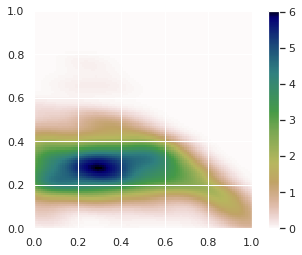

In [9]:
from scipy.stats import gaussian_kde

kernel = gaussian_kde(np.vstack([start, duration]))
X, Y = np.mgrid[0:1:100j, 0:1:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)
plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[0, 1, 0, 1])
plt.colorbar()

# Evaluation

In [10]:
def non_maximum_suppression(bbox, thresh, score=None, limit=None):
    if len(bbox) == 0:
        return np.zeros((0,), dtype=np.int32)

    if score is not None:
        order = score.argsort()[::-1]
        bbox = bbox[order]
    bbox_area = bbox[:, 1] - bbox[:, 0]

    selec = np.zeros(bbox.shape[0], dtype=bool)
    
    for i, b in enumerate(bbox):
        if not bbox_area[i] > 0:
            continue
            
        if not selec.any():
            selec[i] = True
            continue
            
        st = np.maximum(b[0], bbox[selec, 0])
        ed = np.minimum(b[1], bbox[selec, 1])
        area = (ed - st) * (st < ed)
            
        iou = area / (bbox_area[i] + bbox_area[selec] - area)
        
        # when the temporal bbox highly overlap with any of selected bbox
        if (iou >= thresh).any(): 
            continue

        selec[i] = True
        if limit is not None and np.count_nonzero(selec) >= limit:
            break
    
    selec = np.where(selec)[0]
    if score is not None:
        selec = order[selec]
    return selec.astype(np.int32)

In [11]:
test = DescriptionData('data/processed/test.csv',
                  dict_file,
                  san_check=False)

N = 200
test_iter = DataLoader(test, b_size, shuffle=False, collate_fn=proc_batch)
query_net.eval()
boundary_dist.eval()

with torch.no_grad():
    res = []
    for batch in test_iter:
        desc, time_stamp = batch
        desc = desc.to(device)

        h = query_net(desc)
        d = boundary_dist(h)

        sample = d.sample((N,))
        scores = d.log_prob(sample)

        sample = sample.cpu()
        scores = scores.cpu()

        label_05 = get_label(sample, time_stamp, thresh=.5).numpy()
        label_07 = get_label(sample, time_stamp, thresh=.7).numpy()


        for i in range(sample.shape[1]):
            selected = np.zeros((1,))
            thresh = .3
            while(selected.size < 5):
                st = sample[:,i,0].numpy()
                ed = sample[:,i,:].sum(axis=1).numpy()
                t_box = np.stack([st,ed],axis=1)
                selected = non_maximum_suppression(t_box,
                                                   thresh,
                                                   scores[:,i].numpy())
                thresh += 0.2

            y = {
                'y': sample[selected, i, :],
                's': scores[selected, i],
                'label_05': label_05[selected, i],
                'label_07': label_07[selected, i],
                't': time_stamp[i].numpy()
            }

            res.append(y)

In [12]:
R_at_1 = sum([r['label_05'][0].item() for r in res])/len(res)
R_at_5 = sum([r['label_05'][:5].any() for r in res])/len(res)
print(f"R@1 (IOU>.5): {R_at_1}")
print(f"R@5 (IOU>.5): {R_at_5}")

R_at_1 = sum([r['label_07'][0].item() for r in res])/len(res)
R_at_5 = sum([r['label_07'][:5].any() for r in res])/len(res)
print(f"R@1 (IOU>.7): {R_at_1}")
print(f"R@5 (IOU>.7): {R_at_5}")

R@1 (IOU>.5): 0.23440860215053763
R@5 (IOU>.5): 0.810752688172043
R@1 (IOU>.7): 0.08629032258064516
R@5 (IOU>.7): 0.41317204301075267


max iou: 0.7


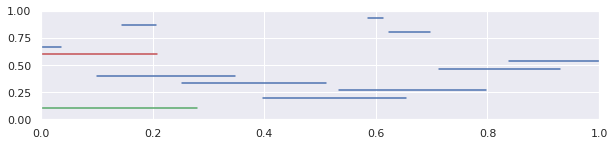

In [18]:
# show example
i = np.random.randint(len(res))
true_s, true_d = res[i]['t']
true_e = true_s + true_d
plt.figure(figsize=(10, 2))
plt.axhline(0.1, true_s, true_s+true_d, color='g')
plt.xlim((0, 1))
plt.ylim((0, 1))

p_item = res[i]['y']
# p_item = p_item.reshape(-1, 2)
offset = 0.2
iou_val = []
lines = []
for pred_s, pred_d in p_item:
    pred_e = pred_s+pred_d
    line = plt.axhline(offset, pred_s, pred_e, color='b')
    offset += (0.8/len(p_item))
    iou_val.append(iou(pred_s, pred_e, true_s, true_e))
    lines.append(line)
print('max iou: %.1f' % max(iou_val))
if max(iou_val) > 0:
    lines[np.argmax(iou_val)].set_color('r')


In [21]:
d.sample((3,)).shape

torch.Size([3, 20, 2])